# The virtue of complexity everwhere

This notebook investigates the findings discussed in Kelly et al 2022. They focus on the behaviour of the prediction model particularly when the number of predictors greatly exceeds the number of sample size. Their result showed that with random non-linear predictors, out-of-sample Sharpe ratio is monotonically increasing in complexity in all asset classes. 

In [1]:
from datetime import datetime
from itertools import cycle, product
from pathlib import Path
import logging

import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn.linear_model import Ridge
from tqdm import tqdm
from joblib import Parallel, delayed

from vivace.backtest.contract import InstrumentDef
from vivace.backtest.engine import BacktestEngine, long_only_returns
from vivace.enums import Strategy

# Data preparation

In [2]:
ticker = 'CL'

## Raw returns

In this notebook we try to predict the return of WTI futures. `raw_returns` is nothing but daily returns of rolling the front contract of futures. In the paper this corresponds to $\tilde{R}$ 

In [3]:
raw_returns = long_only_returns(ticker)

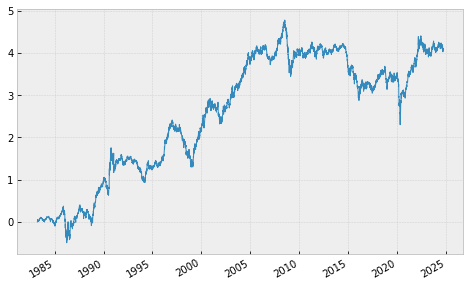

In [4]:
raw_returns.cumsum().plot(figsize=(8, 5), lw=1);

We aim to predict volatility-adjusted returns, calculated based on the trailing 60-day rolling standard deviation. To avoid excessive leverage, realised volatility below the trailing 10th percentile is trimmed.

In [5]:
returns_std = raw_returns.rolling(60).std()
returns_std = returns_std.clip(returns_std.rolling(252).quantile(0.1), None)

In [6]:
vol_adjusted_weekly_returns = (raw_returns.resample('W').sum() /
                               returns_std.shift().asfreq('W', method='pad').shift()).dropna()
vol_adjusted_weekly_returns = vol_adjusted_weekly_returns.astype(np.float32)

In [7]:
len(vol_adjusted_weekly_returns)

2151

## Raw signals

The usual momentum and carry signals are considered using multiple lookback windows. To ensure equal treatment of all features, they are standardised in the same manner as the returns. This is particularly important because a ridge regression will be employed, where the loss is penalised based on the magnitude of the coefficients. Standardisation prevents the penalisation of certain coefficients solely due to their larger values.

### Momentum

The momentum signal is based on the trailing rolling average of volatility-adjusted returns.

In [8]:
momentum_lookback = [21, 63, 126, 252]

In [9]:
vol_adjusted_daily_returns = raw_returns / returns_std

In [10]:
momentum_signal = pd.concat([vol_adjusted_daily_returns.rolling(i).mean().rename(f'mom_{i}') for i in momentum_lookback], axis=1)

### Carry

The carry signal is calculated based on the price of the first contract and that of the second contract, as follows:

$$
C_t = \frac{F_{t, 1} - F_{t, 2}}{F_{t, 1}}
$$

where $F_{t, 1}$ represents the price of the first contract and $F_{t, 2}$ represents the price of the second contract.

In [11]:
engine_1st = BacktestEngine(
    instrument=InstrumentDef(ticker, nth_expiry=1),
    strategy=Strategy.DELTA_ONE.value,
    log_level=logging.WARNING,
)
engine_1st.run()

In [12]:
engine_2nd = BacktestEngine(
    instrument=InstrumentDef(ticker, nth_expiry=2),
    strategy=Strategy.DELTA_ONE.value,
    log_level=logging.WARNING,
)
engine_2nd.run()

In [13]:
futures_price = pd.concat((
    engine_1st.get_generic_price().squeeze().rename('1st'),
    engine_2nd.get_generic_price().squeeze().rename('2nd'),
), axis=1)

In [14]:
carry = (futures_price['1st'] - futures_price['2nd']).div(futures_price['2nd']).ffill()

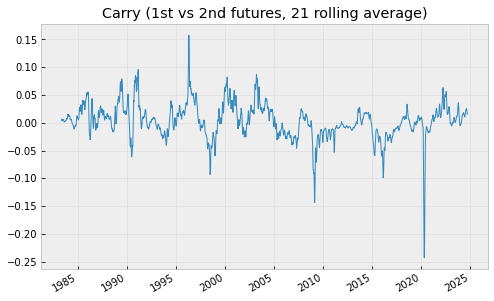

In [15]:
carry.rolling(21).mean().plot(figsize=(8, 5), lw=1, title='Carry (1st vs 2nd futures, 21 rolling average)');

In [16]:
carry_lookback = [21, 63, 126, 252]

In [17]:
carry_signal = pd.concat([carry.rolling(i).mean().rename(f'carry_{i}') for i in carry_lookback], axis=1)

### Starndardise

In [18]:
signals = pd.concat((momentum_signal, carry_signal), axis=1)

In [19]:
signals_std = signals.rolling(60).std()
signals_std = signals_std.clip(signals_std.rolling(252).quantile(0.1), None)
standardised_signal = signals.div(signals_std, axis=0).clip(-5, 5)
standardised_signal = standardised_signal.shift().asfreq('W', method='pad').shift()

For futures data the authors assume weekly rebalancing.

## Clean up

To conserve memory usage, all data is converted to the float32 type.

In [20]:
standardised_signal = standardised_signal.astype(np.float32)

In [21]:
standardised_signal.dtypes

mom_21       float32
mom_63       float32
mom_126      float32
mom_252      float32
carry_21     float32
carry_63     float32
carry_126    float32
carry_252    float32
dtype: object

# Regression

In this section we run a ridge regression with random features. The meaning of the variables used below is as follows:

- `seed_list` is the random seed $s$
- `gamma_list` is the weight in front of the transformed signal acting as the hidden layer. Originally this is coming from the bandwidth of the Gaussian kernel.
- `shrinkage_list` is the shrinkage parameter $log(z)$ 
- `rolling_window_list` is the rolling training window $T$
- `n_random_features_list` is the number of features used in the regression $L$

$c$ is the ratio between the number of features and the sample size, $c=\frac{L}{T}$. Tha largest number of $L$ exceeds that investigated in the original paper (1000 * $T$) as more features were required for the results to converge sufficiently.

## random features

In [22]:
c = 20
seed_list = range(0, 100)
gamma_list = [0.1, 0.5, 1, 2, 4, 8, 16]
shrinkage_list = [-3, -2, -1, 0, 1, 2, 3]
rolling_window_list = [12, 60, 120]
n_random_features_list = [l for i in range(1, 20) if (l := (2 ** i)) <= (c * len(standardised_signal))]
activation_function_list = [np.sin, np.cos]

In [23]:
def calc_random_features(
    signal: pd.DataFrame,
    seed: float,
    gamma_list: list[float],
    c: int,
    activation_function_list: list,
) -> pd.DataFrame:
    """ Calculate the random features """
    generator = np.random.default_rng(seed=seed)
    max_n_random_features = c * signal.shape[0]
    w = generator.normal(size=(signal.shape[1], max_n_random_features)).astype(np.float32)
    gamma_cycle = cycle(gamma_list)
    gamma_list = [next(gamma_cycle) for _ in range(max_n_random_features)]
    gamma_list = pd.Series(gamma_list).astype(np.float32)
    
    random_features = gamma_list * signal.dot(w)
    
    activation_function_cycle = cycle(activation_function_list)
    random_features = pd.concat([random_features[col_name].apply(func) for col_name, func in zip(random_features.columns, activation_function_cycle)], axis=1)
    random_features *= max_n_random_features ** -0.5
    return random_features

In [24]:
s = calc_random_features(standardised_signal, 1, gamma_list, c, activation_function_list)

In [25]:
s.loc[:, :2].dtypes

0    float32
1    float32
2    float32
dtype: object

In [26]:
s.shape

(2164, 43280)

In [27]:
s.memory_usage(deep=True).sum() / 1024 ** 3

np.float64(0.3489190638065338)

In [28]:
s.tail()

,0,1,2,3,4,5,6,7,8,9,...,43270,43271,43272,43273,43274,43275,43276,43277,43278,43279
2024-08-18,-0.001281,0.004564,-0.001690,0.000960,-0.000863,0.004801,0.000436,0.002308,-0.003853,0.000199,...,0.000874,-0.000530,0.001551,-0.004692,-0.003035,0.004629,0.003382,-0.000309,-0.004616,0.001903
2024-08-25,-0.001207,0.004095,-0.004804,-0.002531,0.003341,-0.003654,0.004595,0.002118,-0.004650,-0.001928,...,0.000333,0.002639,-0.003145,-0.004791,-0.002724,0.004086,0.004315,-0.004756,0.000177,0.001031
2024-09-01,-0.000934,0.000161,-0.000642,-0.002814,0.002744,-0.003146,-0.004214,0.002566,-0.004521,0.001075,...,-0.004806,-0.004490,0.004801,0.002095,-0.002736,0.004607,0.004728,0.004236,-0.003992,-0.002353
2024-09-08,-0.000903,0.001209,-0.002483,-0.000061,0.004770,-0.003175,-0.003497,0.002611,-0.004390,-0.000913,...,0.004116,-0.003652,0.003986,0.001106,-0.002260,0.004806,0.004796,0.000965,0.003798,0.004702
2024-09-15,-0.000303,0.000609,0.004553,0.004562,0.003399,0.004658,0.004496,0.002522,-0.004807,-0.000534,...,0.004658,0.004467,0.004639,-0.001613,-0.002584,0.000469,0.004787,0.001355,0.003648,-0.000007


## Run for loop

As described in the paper, we iterate rolling Ridge regressions with varying parameters to examine the relationship between out-of-sample performance and these parameters.

In [29]:
def run_rolling_regression(
    signals: pd.DataFrame, 
    target: pd.Series,
    n_random_features: int,
    rolling_window: int,
    shrinkage: float,
) -> pd.DataFrame:
    """ Run rolling Ridge regression """
    predict_result = []
    train_x_all = signals.sample(n_random_features, axis=1)
    
    for idx, t in enumerate(target.index):
        train_x = train_x_all.loc[:t].tail(rolling_window).dropna()
        train_y = target.loc[:t].tail(rolling_window)

        pred_idx = idx + 1
        if (len(train_y) == len(train_x) == rolling_window) and (pred_idx < len(target)):
            # train the ridge regression
            model = Ridge(alpha=10 ** shrinkage, fit_intercept=False)
            model.fit(train_x, train_y)
            # predict
            test_t = target.index[pred_idx]
            test_x = train_x_all.loc[[test_t]]
            test_y = target.loc[test_t]
            pi = model.predict(test_x)[0]
            predict_result.append([
                test_t,
                test_y,
                pi,
                (model.coef_ ** 2).sum() ** 0.5,
            ])
            # break
    predict_result = pd.DataFrame(predict_result, columns=['test_t', 'test_y', 'predicted', 'beta_sq']).set_index('test_t')
    return predict_result


def run_one_iteration(
    signals: pd.DataFrame, 
    target: pd.Series,
    n_random_features: int,
    rolling_window: int,
    shrinkage: float,
) -> dict:
    """ Run one iteration and compile the result """
    predict_result = run_rolling_regression(
        s,
        vol_adjusted_weekly_returns,
        n_random_features,
        rolling_window,
        shrinkage,
    )
    
    # eq 41
    r_sq = 1 - ((predict_result['test_y'] - predict_result['predicted']).pow(2).sum() / 
                (predict_result['test_y'] - predict_result['test_y'].mean()).pow(2).sum())
    # eq 42
    beta_sq = predict_result['beta_sq'].mean()
    # eq 43
    timing_strategy = predict_result['test_y'] * predict_result['predicted']
    # eq 44
    er = timing_strategy.mean()
    # eq 45
    vol = timing_strategy.var()
    # eq 46 (note this is not annualised)
    sr = er / (vol ** 0.5)

    summary = {
        'z': shrinkage, 
        'T': rolling_window, 
        'L': n_random_features, 
        'r_sq': r_sq, 
        'beta_sq': beta_sq, 
        'er': er, 
        'vol': vol, 
        'sr': sr,
    }
    return summary

In [30]:
output_path = Path(f'regression_summary_c{c}.pkl')
output_path

PosixPath('regression_summary_c20.pkl')

In [31]:
if output_path.exists():
    regression_summary = pd.read_pickle(output_path)

else:
    parallel = Parallel(n_jobs=10)
    delayed_func = delayed(run_one_iteration)
    
    regression_summary = []
    
    for seed in tqdm(seed_list, leave=False, desc='Random seed'):
        s = calc_random_features(standardised_signal, seed, gamma_list, c, activation_function_list)

        result = parallel(
            delayed_func(s, vol_adjusted_weekly_returns, n_random_features, rolling_window, shrinkage) 
            for shrinkage, rolling_window, n_random_features in product(shrinkage_list, rolling_window_list, n_random_features_list)
        )
        regression_summary += result
        # break
    
    regression_summary = pd.DataFrame(regression_summary)
    regression_summary.to_pickle(output_path)

In [32]:
regression_summary.head()

,z,T,L,r_sq,beta_sq,er,vol,sr
0,-3,12,2,-0.000679,30.215334,0.008246,0.091417,0.027272
1,-3,12,4,-0.006439,43.207237,-0.002536,0.141207,-0.006749
2,-3,12,8,-0.015746,58.980587,-0.017306,0.258593,-0.034032
3,-3,12,16,-0.010717,79.114281,0.017849,0.555887,0.023939
4,-3,12,32,-0.029318,95.518951,0.032429,1.392740,0.027479


# The VoC curves

The purporse of running rolling regressions is to understand the behaviour of out-of-sample predictions in relation to model complexity. In the following charts, as in the original paper, we present the relationship between model accuracy metrics such as $R^2$, $\left \| \beta \right \|$, expected returns, volatility and Sharpe ratio, and model complexity.

## Result ($T=12$)

In [33]:
def plot_r2_and_beta(t: int):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    regression_summary.query(f'T == {t}').pivot_table('r_sq', index='L', columns='z').plot(ax=ax[0], cmap='rainbow');
    regression_summary.query(f'T == {t}').pivot_table('beta_sq', index='L', columns='z').plot(ax=ax[1], cmap='rainbow');
    
    ax[0].set_title(r'Out-of-sample prediction accuracy: $R^2$')
    ax[1].set_title(r'Out-of-sample prediction accuracy: $\left \| \beta \right \|$')
    for ax_i in ax:
        ax_i.axvline(t, lw=1, color='black', ls='--', label='c=1')
        ax_i.legend();
    fig.tight_layout();

def plot_er_and_vol(t: int):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    regression_summary.query(f'T == {t}').pivot_table('er', index='L', columns='z').plot(ax=ax[0], cmap='rainbow');
    regression_summary.query(f'T == {t}').pivot_table('vol', index='L', columns='z').plot(ax=ax[1], cmap='rainbow');
    
    ax[0].set_title(r'Out-of-sample prediction accuracy: Expected return')
    ax[1].set_title(r'Out-of-sample prediction accuracy: Volatility')
    for ax_i in ax:
        ax_i.axvline(t, lw=1, color='black', ls='--', label='c=1')
        ax_i.legend();
    fig.tight_layout();

def plot_sr(t: int):
    ax = regression_summary.query(f'T == {t}').pivot_table('sr', index='L', columns='z').plot(figsize=(8, 5), cmap='rainbow');
    ax.set_title(r'Out-of-sample prediction accuracy: Sharpe ratio')
    ax.axvline(t, lw=1, color='black', ls='--', label='c=1')
    ax.legend();

As stated in the paper, $R^2$ is generally negative and serves a poor accuracy metric. The large negative $R^2$ is a result of insufficient shrinkage.

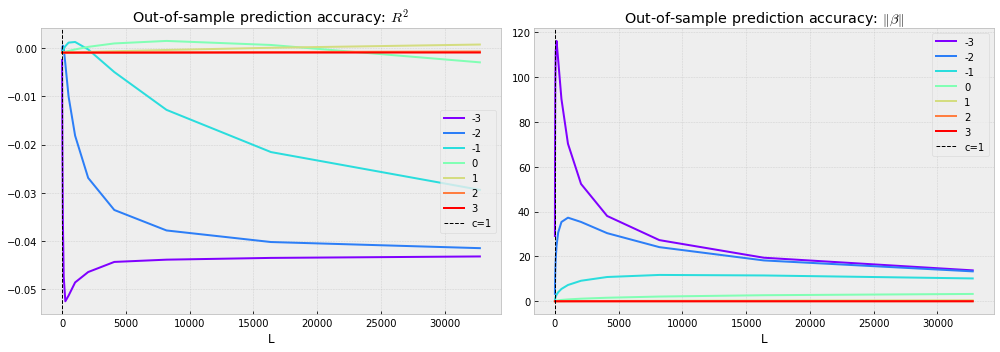

In [34]:
plot_r2_and_beta(12)

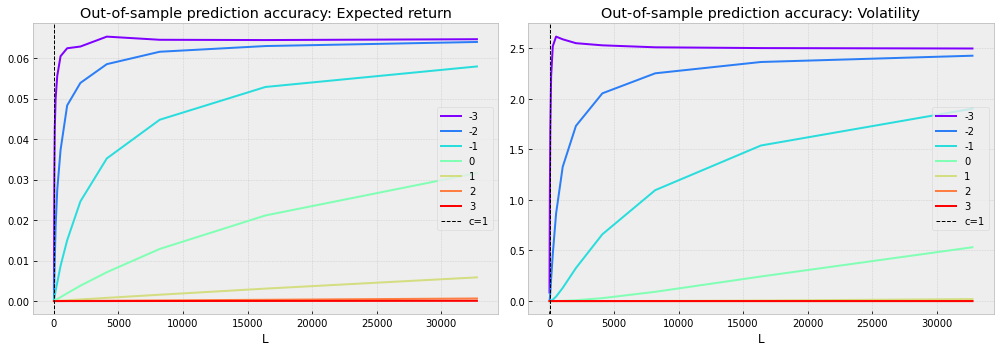

In [35]:
plot_er_and_vol(12)

Expected retrun increases monotonically in complexity.

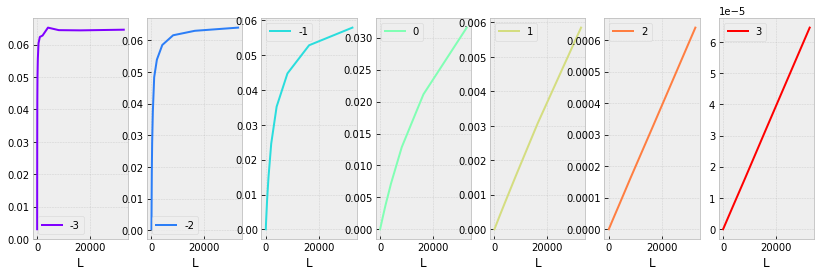

In [36]:
regression_summary.query('T == 12').pivot_table('er', index='L', columns='z').plot(figsize=(14, 4), subplots=True, layout=(1, 7), cmap='rainbow');

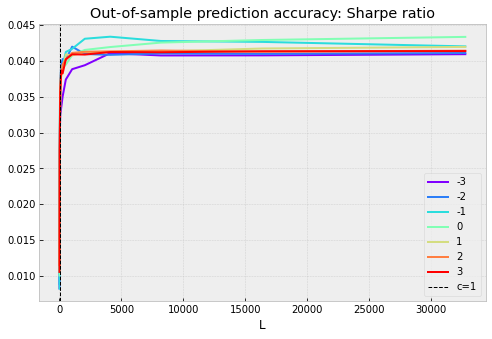

In [37]:
plot_sr(12)

In [38]:
def plot_individual_sr(t: int):
    fig, ax = plt.subplots(1, len(shrinkage_list), figsize=(18, 4), sharey=True)
    for idx, z in enumerate(shrinkage_list):
        tmp_df = regression_summary.query(f'T == {t} and z == {z}')[['L', 'sr']]
        unique_l = tmp_df['L'].unique()
        tmp_df = pd.concat([tmp_df.query(f'L == {i}')['sr'].reset_index(drop=True).rename(i) for i in unique_l], axis=1).T
        
        tmp_df.plot(legend=False, color='grey', lw=1, alpha=0.1, ax=ax[idx], title=f'{z=}')
        tmp_df.mean(axis=1).plot(ax=ax[idx], color='red', lw=1)
        tmp_df.quantile(0.05, axis=1).plot(ax=ax[idx], color='blue', lw=1, ls='--')
        tmp_df.quantile(0.95, axis=1).plot(ax=ax[idx], color='blue', lw=1, ls='--')
    ax[0].set_ylabel('OOS Sharpe ratio')

Similar to expected returns, the Sharpe ratio also increases monotonically. The chart below illustrates how the Sharpe ratio evolves as model complexity increases for each random seed. The variation in the Sharpe ratio, measured by its standard deviation, decreases with higher levels of shrinkage.

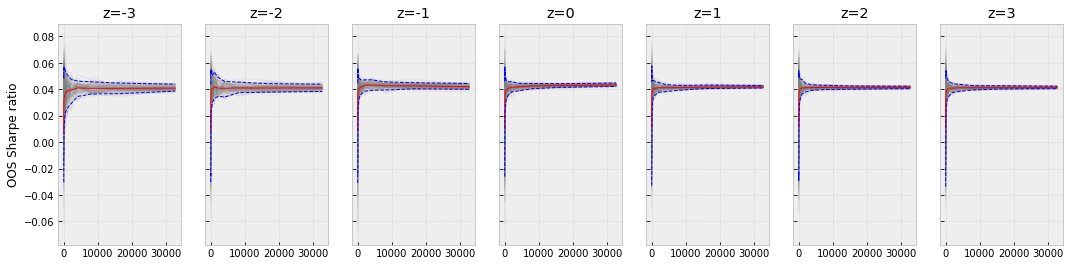

In [39]:
plot_individual_sr(12)

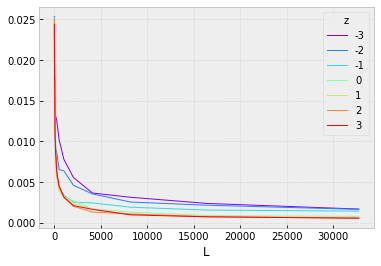

In [40]:
regression_summary.query('T == 12').groupby(['L', 'z'])['sr'].std().reset_index().pivot_table('sr', columns='z', index='L').plot(cmap='rainbow', lw=1);

## Result ($T=60$)

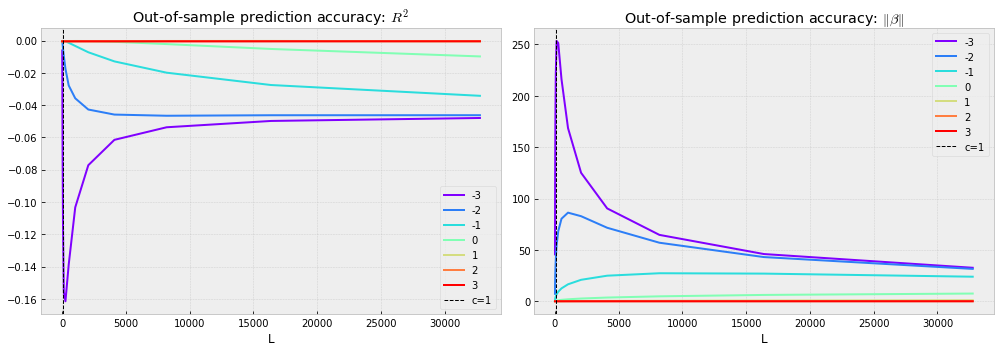

In [41]:
plot_r2_and_beta(60)

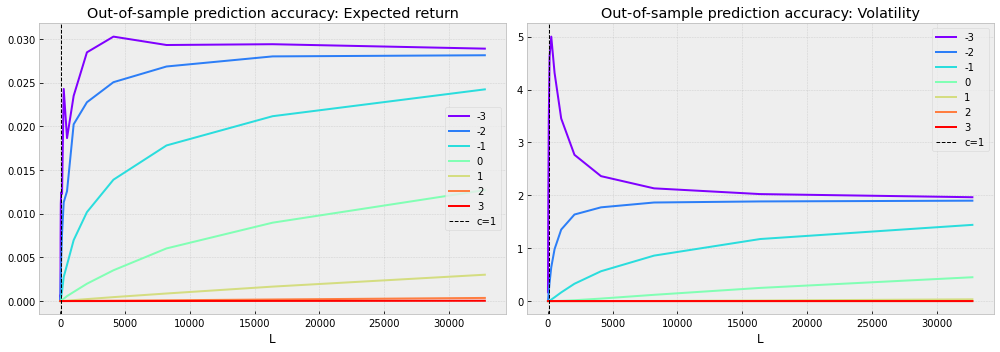

In [42]:
plot_er_and_vol(60)

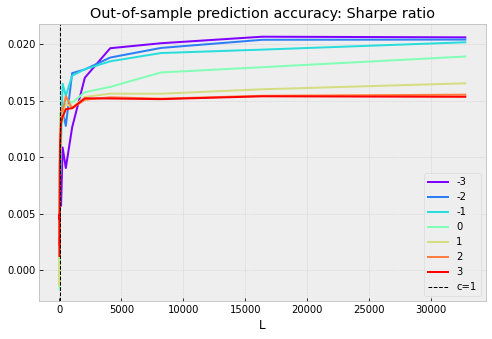

In [43]:
plot_sr(60)

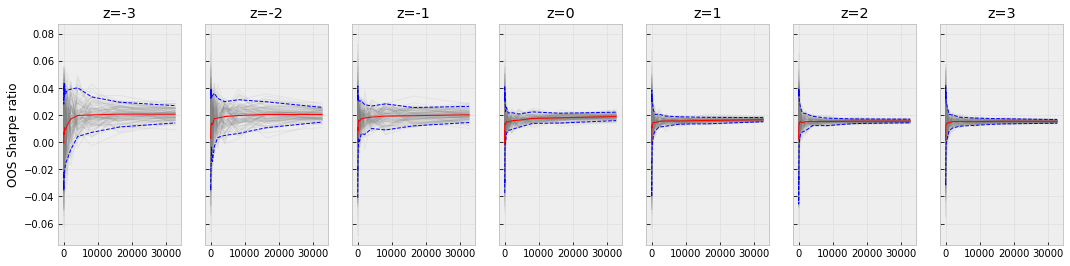

In [44]:
plot_individual_sr(60)

## Result ($T=120$)

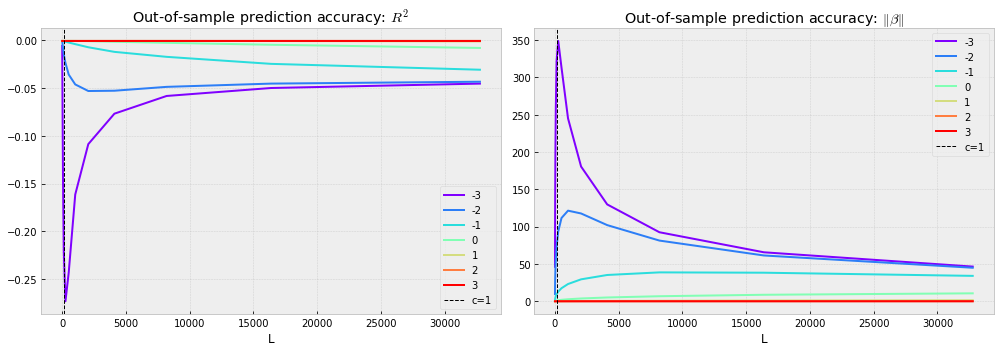

In [45]:
plot_r2_and_beta(120)

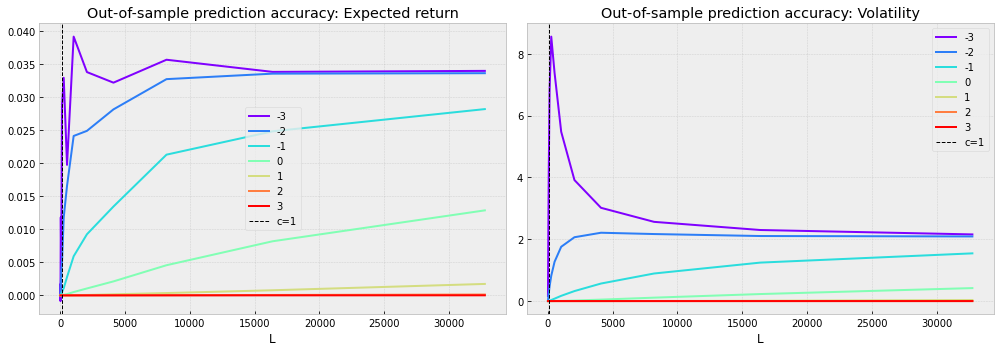

In [46]:
plot_er_and_vol(120)

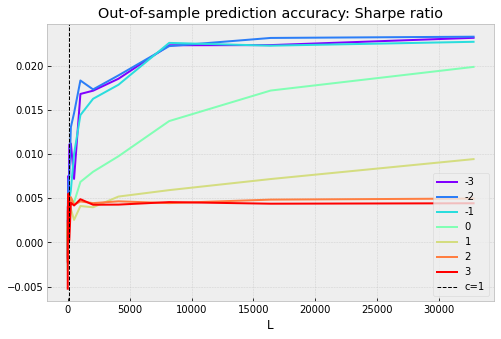

In [47]:
plot_sr(120)

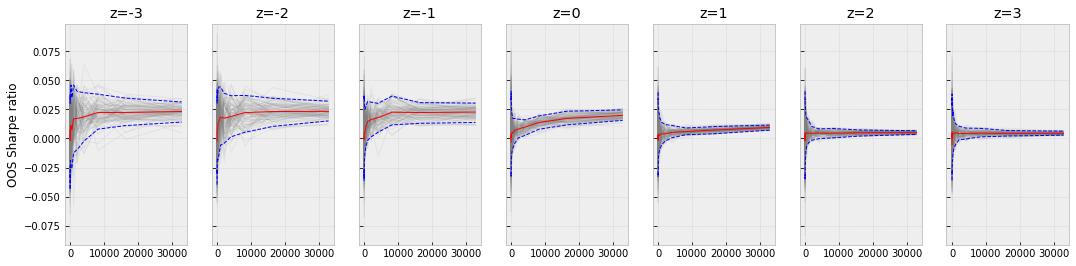

In [48]:
plot_individual_sr(120)

# Reference
- Kelly, B.T., Malamud, S. and Zhou, K., 2022. The virtue of complexity everywhere. _Available at SSRN 4166368_.
- Kelly, B., Malamud, S. and Zhou, K., 2024. The virtue of complexity in return prediction. The Journal of Finance, 79(1), pp.459-503.

In [49]:
print(f'Updated: {datetime.now(pytz.utc).strftime("%d-%b-%Y %H:%M")}')

Updated: 23-Sep-2024 21:23
